# Target Encoding

- target으로부터 유래된 변수의 categories를 대체하는 encoding의 종류이다.
- 간단한 예시 중 하나는, vehicle의 종류에 따른 가격을 평균내어 새로운 변수를 만든다.
    - mean encoding
    - bin counting : binary target에 적용시
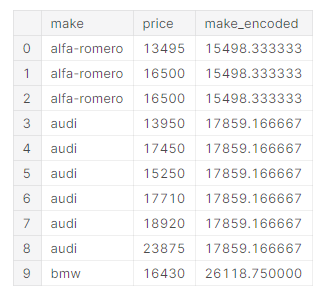

# Smoothing

- encoding을 하는데 있어 몇가지 문제가 존재하는데 다음과 같다.

1) unkown categories 

    - missing value에 대해서 어떤 방법으로든 대체해야하는데서 발생하는 문제 => create a special risk of overfitting
    
2) rare categories

    - 데이터셋에서 특정 카테고리가 거의 일어나지 않는다면 그 그룹에서의 계산된 통계는 거의 정확하지 않다.
    - "mean" 으로 계산된 price는 한 vehicle에 대한것이지 특정 그룹을 대표할 수 없는 수치가 될 수 있다. => overfitting

- **위의 두가지 문제를 해결하는 방법이 바로 smoothing 을 더하는 것이다.**
    - 즉, 아이디어는 카테고리 내의 평균을 전체 평균과 혼합하는 것이다.
    - 이를 통해, rare categories는 낮은 weight를 그들의 category 평균에서 얻게 되고, missing categroies는 전체적인 평균을 얻게 된다.
    - 가중평균해주는것!!! (weight = n / (n+m) )

- 이는 high-cardinality features에 적합할 수 있다. (모두 원핫인코딩 하면 너무 고차원이 되어버리므로)
    

In [4]:
pip install --upgrade category_encoders

Note: you may need to restart the kernel to use updated packages.


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Matplotlib 세팅
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


# xgbregressor 관련 점수 도출
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

df = pd.read_csv("data/ames.csv")

#### rare categories에 적합한 M-estimate encoding을 적용

In [24]:
df.select_dtypes(["object"]).nunique()

MSSubClass       16
MSZoning          7
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     28
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          6
BsmtCond          6
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            5
Fence             5
MiscFeature       6
SaleType         10
SaleCondition     6
dtype: int64

In [25]:
# rare attribute존재!
df["SaleType"].value_counts()

WD       2536
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: SaleType, dtype: int64

In [26]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

In [27]:
# 위에서 sample로 뽑은 encode index에 해당하는 saleprice삭제
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")
X_pretrain

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,120.0,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,160.0,20000.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,No_Fence,None,0.0,9,2006,WD,Abnorml
2925,Split_or_Multilevel,Residential_Low_Density,37.0,7937.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,0.0,0.0,No_Pool,Good_Privacy,None,0.0,3,2006,WD,Normal
2926,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0.0,8885.0,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2006,WD,Normal
2927,Split_Foyer,Residential_Low_Density,62.0,10441.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,Shed,700.0,7,2006,WD,Normal


In [28]:
encoder = MEstimateEncoder(
    cols=["Neighborhood"],
    m=1.0,
)
# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

In [29]:
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,120.0,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,160.0,20000.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,No_Fence,None,0.0,9,2006,WD,Abnorml
2925,Split_or_Multilevel,Residential_Low_Density,37.0,7937.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,0.0,0.0,No_Pool,Good_Privacy,None,0.0,3,2006,WD,Normal
2926,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0.0,8885.0,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2006,WD,Normal
2927,Split_Foyer,Residential_Low_Density,62.0,10441.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,Shed,700.0,7,2006,WD,Normal


In [30]:
encoder.cols

['Neighborhood']

In [31]:
# Try experimenting with the smoothing parameter m
# Try 0, 1, 5, 50
m = 0

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0  # actually need one duplicate value to circumvent error-checking in MEstimateEncoder

# fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# Results
score =  score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")

Score: 0.0293 RMSLE


In [32]:
# Try experimenting with the smoothing parameter m
# Try 0, 1, 5, 50
m = 5

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0  # actually need one duplicate value to circumvent error-checking in MEstimateEncoder

# fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# Results
score =  score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")

Score: 0.0291 RMSLE
